            ----- MADRS prediction 96h segments -----

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

In [2]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 5760

Function for creating the segments and corresponding labels for MADRS prediction
 - it will read scores.csv (with all the demographics etc), and generates:
     -> one list of time sliced sequences
     -> one list of the corresponding participants' labels (madrs scores)

In [11]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[  0., 143.,   0., ..., 277., 227., 386.],
       [306., 286.,  12., ..., 102.,  61.,  15.],
       [  0.,   0.,  21., ...,  61., 250., 197.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 5760)


Splitting dataset, later I will add a validation set as well

In [4]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(16752, 5760)

(4189, 5760)

(16752,)

(4189,)


Normalization

In [5]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(16752, 5760)

(4189, 5760)

(16752, 1)

(4189, 1)


Reshaping, otherwise it won't fit in the LSTM model

In [6]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

print(X_train_scaled_res.shape)
print()
print(y_train_scaled_res.shape)
print()
print(X_test_scaled_res.shape)
print()
print(y_test_scaled_res.shape)

(16752, 5760, 1)

(16752, 1, 1)

(4189, 5760, 1)

(4189, 1, 1)


Building LSTM model

In [12]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='lecun_normal', activation='linear'))
    model.compile(optimizer = optimizer, 
                  loss = 'mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])

    
    return model

Cross-validation + validation samples

In [13]:
train_data = X_train_scaled_res
train_targets = y_train_scaled_res
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['root_mean_squared_error']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_root_mean_squared_error']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
698/698 [==============================] - 5827s 8s/step - loss: 0.1377 - root_mean_squared_error: 0.3707 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3460
Epoch 2/4
698/698 [==============================] - 5825s 8s/step - loss: 0.1206 - root_mean_squared_error: 0.3472 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 3/4
698/698 [==============================] - 5888s 8s/step - loss: 0.1206 - root_mean_squared_error: 0.3472 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 4/4
698/698 [==============================] - 5785s 8s/step - loss: 0.1206 - root_mean_squared_error: 0.3473 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3455
processing fold # 1
Epoch 1/4
698/698 [==============================] - 5945s 9s/step - loss: 0.1502 - root_mean_squared_error: 0.3867 - val_loss: 0.1184 - val_root_mean_squared_error: 0.3440
Epoch 2/4
698/698 [==============================] - 5908s 8s/step - loss: 0.1216 - root_mean_s

In [25]:
print(np.mean([0.1194,0.1180,0.1183]))

0.11856666666666667


In [17]:
print("RMSE of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean RMSE of all folds:\n")
print(np.mean(all_scores))

RMSE of fold 1, 2 and 3:

[0.3455011248588562, 0.34346023201942444, 0.3439597487449646]

Mean RMSE of all folds:

0.3443070352077484


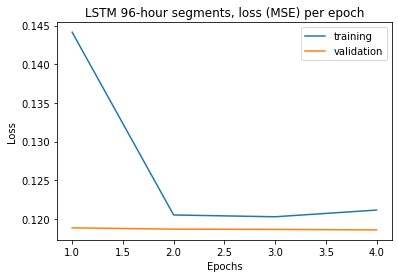

In [26]:
average_loss = [0.14413333333333334,0.1205,0.12026666666666667,0.12113333333333333]
average_val_loss = [0.11883333333333335,0.11866666666666666,0.11863333333333333,0.11856666666666667]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 96-hour segments, loss (MSE) per epoch')
plt.show()

In [27]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

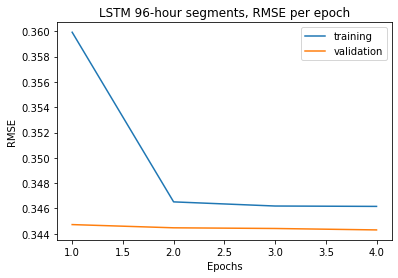

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 96-hour segments, RMSE per epoch')
plt.show()

In [30]:
print(average_mae_history)
print(val_average_mae_history)

[0.3599283794562022, 0.346522976954778, 0.34619521101315814, 0.34616619348526]
[0.344728281100591, 0.34447375933329266, 0.34442028403282166, 0.34430702527364093]
